#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [5]:
def stochastic_modeling(nested_dict, tickers, periods,num_samples,investment_period):
    # Store the returns in a nested dictionary
    nested_dict_returns = {period: {ticker: [] for ticker in tickers} for period in periods}

    # Go through each economic time period
    for period in periods:
        max_index = len(nested_dict[period]) - investment_period  # Ensure there's enough data to calculate ROI

        # Generate random samples from the valid range
        random_dates = random.choices(range(max_index), k=num_samples)

        for ticker in tickers:
            for date_idx in random_dates:
                start_price = nested_dict[period][ticker].iloc[date_idx]
                end_price = nested_dict[period][ticker].iloc[date_idx + investment_period]

                # Get the return by the Holding Period Return
                roi = (((end_price - start_price) / start_price) * 100)

                nested_dict_returns[period][ticker].append(roi)

    return nested_dict_returns  # Return the nested dictionary with returns

In [6]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Bollinger Bands

In [7]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = None

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', np.nan))

        return data

In [8]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')

In [9]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(12,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [10]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Plot data

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [12]:
import matplotlib.pyplot as plt

def plot_sector_investment_changes(sector_allocation, title):

    sector_df = sector_allocation.apply(pd.Series)
    """
    Plots a stacked area chart to track how the investment in different sectors changes over time.

    Parameters:
    sector_df (pd.DataFrame): DataFrame where columns represent sectors and index represents dates.
    title (str): The title of the plot (optional).
    """
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(sector_df.index, sector_df.T, labels=sector_df.columns)
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Allocation Amount')
    plt.legend(loc='upper left')
    
    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)
    plt.grid()

    # Display the plot
    plt.tight_layout()
    plt.show()

    return sector_df


##### Stock Investment History

In [36]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def portfolio_investment(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Track actions day by day for the entire portfolio
    portfolio_tracker = {period: pd.DataFrame(columns=['Date', 'Account Balance', 'Portfolio Value', 'Total Value', 'Profit', 'Sector Allocation']) for period in periods_list}

    # Portfolio summary - nested dictionary for each period and ticker
    portfolio_summary = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods_list}
  
    # Set data to be accessed
    adj_close_data = adj_close_nd
    bollinger_band_data = bb_signals_nd

    all_data = {
        'Stock Tracker': portfolio_summary,
        'Portfolio Tracker': portfolio_tracker,
        'Adjusted Close Price': adj_close_nd,
        'Bollinger Band Signal': bollinger_band_data
    }

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=90))
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=False)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize balance for portfolio investment  
            account_balance = initial_investment
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_data[period].loc[time_stamp:time_stamp + timedelta(days=90)]
            bb_signals_period = bollinger_band_data[period].loc[time_stamp:time_stamp + timedelta(days=90)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                daily_balance_change = 0
                portfolio_value = 0

                # Initialize tracking for each ticker
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Initialize stock tracker for current ticker
                    stock_tracker = all_data['Stock Tracker'][period][ticker]

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance
                        if account_balance >= amount_to_buy:
                            # Calculate shares to buy
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy

                            # Track investment for the current period
                            stock_tracker = stock_tracker.append({
                                'Date': row_idx,
                                'Share Price': adj_close_price,
                                'Signal': 'Buy',
                                'Buy/Sell Amount ($)': amount_to_buy,
                                'Buy/Sell Number of Shares': shares_to_buy,
                                'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                'Shares Ownership': shares_number[ticker]
                            }, ignore_index=True)

                            # Update account balance after buying
                            account_balance -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:  # Ensure we have shares to sell
                            amount_to_sell = percent_to_sell * (shares_number[ticker] * adj_close_price)
                            shares_to_sell = amount_to_sell / adj_close_price
                            if shares_number[ticker] >= shares_to_sell:
                                shares_number[ticker] -= shares_to_sell

                                # Track the sell action
                                stock_tracker = stock_tracker.append({
                                    'Date': row_idx,
                                    'Share Price': adj_close_price,
                                    'Signal': 'Sell',
                                    'Buy/Sell Amount ($)': amount_to_sell,
                                    'Buy/Sell Number of Shares': shares_to_sell,
                                    'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                    'Shares Ownership': shares_number[ticker]
                                }, ignore_index=True)

                                # Update account balance after selling
                                account_balance += amount_to_sell

                    # Handle Hold action (no action taken)
                    else:
                        # Track the hold state
                        stock_tracker = stock_tracker.append({
                            'Date': row_idx,
                            'Share Price': adj_close_price,
                            'Signal': 'Hold',
                            'Buy/Sell Amount ($)': 0,
                            'Buy/Sell Number of Shares': 0,
                            'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                            'Shares Ownership': shares_number[ticker]
                        }, ignore_index=True)

                    # Save the updated tracker back to portfolio summary
                    all_data['Stock Tracker'][period][ticker] = stock_tracker.copy()

                # Calculate total portfolio value for all tickers for the day
                portfolio_value = sum(shares_number[ticker] * adj_close_period.loc[row_idx, ticker] for ticker in tickers)

                # Total value (account balance + portfolio value)
                total_value = account_balance + portfolio_value

                # Calculate profit (difference from initial investment)
                profit = total_value - initial_investment

                # Calculate percentage allocation of each ticker to total portfolio value
                sector_allocation = {ticker: (shares_number[ticker] * adj_close_period.loc[row_idx, ticker]) / portfolio_value * 100 if portfolio_value > 0 else 0 for ticker in tickers}

                # Track portfolio changes for the current day
                portfolio_tracker[period] = portfolio_tracker[period].append({
                    'Date': row_idx,
                    'Account Balance': account_balance,
                    'Portfolio Value': portfolio_value,
                    'Total Value': total_value,
                    'Profit': profit,
                    'Sector Allocation': sector_allocation
                }, ignore_index=True)

            # Update the portfolio tracker for the period
            all_data['Portfolio Tracker'][period] = portfolio_tracker[period]

    # Return the complete portfolio summary for all periods and tickers
    return all_data

In [145]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

In [175]:
def calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=90))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize variables
            account_balance = initial_investment
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: 0 for ticker in tickers}   # Initialize share value for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=90)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=90)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance
                        if account_balance >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance += amount_to_sell

            # Calculate total portfolio value at the end of the period
            portfolio_value = sum(shares_number[ticker] * adj_close_period.iloc[-1][ticker] for ticker in tickers)
            total_value = account_balance + portfolio_value
            
            # Calculate the profit relative to the initial investment
            profit = total_value - initial_investment
            
            # Calculate ROI for each stock as a percentage of the initial investment
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only consider tickers with shares owned
                    roi_dollar_value = shares_value[ticker] - (initial_investment * (percent_to_buy * shares_number[ticker]))

                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

# Chapter 2: Bollinger Bands
Bollinger Bands investing is a popular technical analysis tool created by John Bollinger in the 1980's. They measure market volatility and utilize moving averages to understand whether a stock is overbought or oversold which signals a buy or sell signal. It consists of the following parameters:
- Middle band: The 20 day moving average
- Upper band: The 20 day moving average plus 2 standard deviations of the current moving average
- Lower band: The 20 day moving average minus 2 standard deviations of the current moving average

## Bollinger Bands Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement. This will allow for a better understanding of which sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

Chapter 1's investigation into buy and hold strategies gave a good background into what can be expected of stock performance. This is going to be used as a bench mark to compare the success of the Bollinger Bands.

## Sector ETF and Time Period Setup

In [14]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [15]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [16]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Bollinger Bands Introduction
Bollinger bands require the use of the adjusted close price to create an upper and lower bound from the moving average. Working within the 'sector_etf_data' nested dictionary, the upper, middle and lower bound can be added as columns to the dataframe. This can then create a signal for each day which is going to be combined into one dataframe dependent on the macroeconomic cycle of investment.

In [17]:
# use 20 day moving average
# use a 95% confidence interval (2 standard deviations)
for ticker in sector_etf_tickers:
    bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [18]:
# show an example of XLV healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927486,6053600,NaN,NaN,NaN,nan
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965378,6353400,NaN,NaN,NaN,nan
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,NaN,NaN,NaN,nan
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631422,8545000,NaN,NaN,NaN,nan
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108452,5060200,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404514,3655700,19.163588,20.034958,18.292217,nan
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580986,4412900,19.221133,20.041095,18.401172,nan
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381500,4591100,19.265252,20.016430,18.514075,nan


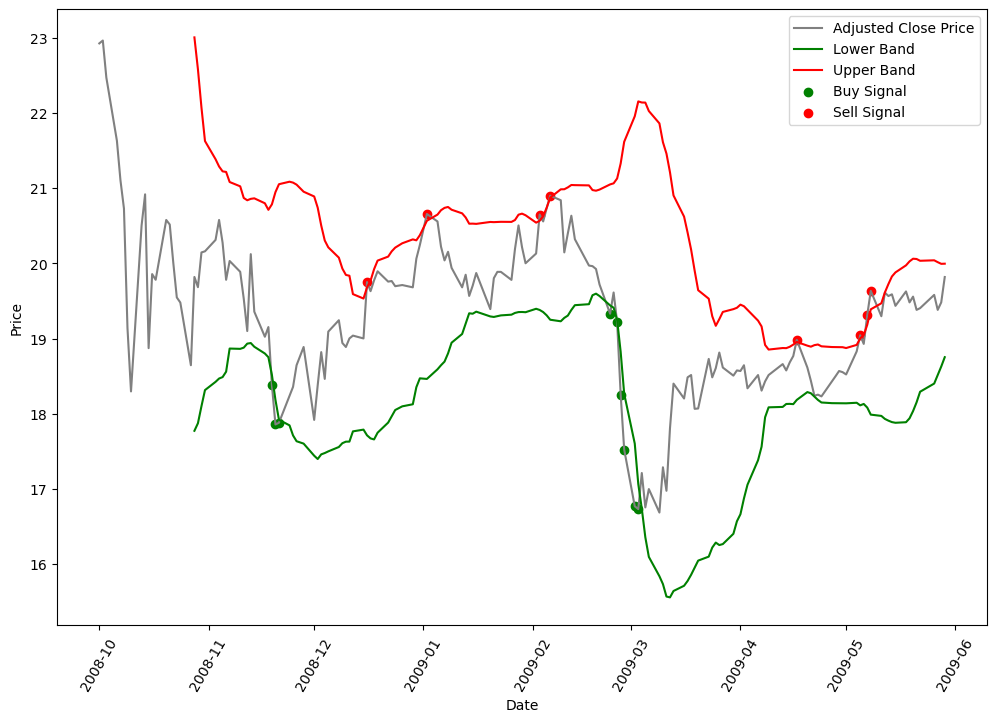

In [19]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(sector_etf_data['trough']['XLV'])

## Stochastic Modeling for Bollinger Bands
Stochastic modeling is going to be slightly different. There needs to be 2 dataframes associated with the investment. There needs to a signal dataframe and the adjusted close price dataframe. The signal dataframe is the different tickers signal for each day meanwhile the adjusted close price is the dataframe with the closing adjusted price for each ticker. When there is a signal to buy or sell you need to get the adjusted close price data from the other dataframe in order to update the investment.

In [20]:
# get the adjusted close price dataframe
sector_etf_closed_price = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [21]:
# load in the dataframe for the trough time period
sector_etf_closed_price['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119270,21.858334,12.413445,15.649678,22.589607,18.009497,37.393242,22.927486,36.648045,18.666508,34.011742
2008-10-02,21.458338,20.549889,11.794876,15.037062,21.771828,17.782763,35.261116,22.965378,35.561878,18.395731,31.759169
2008-10-03,21.247194,20.222775,11.278399,14.822246,21.010748,17.640251,34.840698,22.472727,35.039402,18.119318,30.064146
2008-10-06,20.198568,19.692122,10.689856,14.002766,20.419697,17.128462,32.966827,21.631422,33.396400,17.233656,29.512159
2008-10-07,19.156967,19.037899,9.560816,13.286716,19.108042,16.584293,31.159039,21.108452,31.966496,16.528513,27.019825
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848715,16.073534,7.178291,13.618083,18.520390,15.070188,29.497372,19.404514,33.037407,14.918161,18.541616
2009-05-26,19.300220,16.658958,7.412233,13.971807,19.143747,15.260777,30.122391,19.580986,34.221874,15.351323,19.500559
2009-05-27,18.576378,16.117987,7.190603,13.835135,18.725441,14.873021,29.794701,19.381500,33.881413,15.039441,18.851515


In [22]:
# get the signals for tickers
bb_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [23]:
# get the bollinger band signals for trough
# nan represent no purchase or sell (hold)
bb_signals['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-05-26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-05-27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [24]:
# ensure that the dataframe has buy and sell signals
for ticker in sector_etf_tickers:
    print(bb_signals['trough'][ticker].value_counts())

nan     158
Sell      5
Buy       3
Name: XLB, dtype: int64
nan     150
Buy       8
Sell      8
Name: XLI, dtype: int64
nan     148
Buy      13
Sell      5
Name: XLF, dtype: int64
nan     156
Sell      8
Buy       2
Name: XLK, dtype: int64
nan     153
Sell      7
Buy       6
Name: XLY, dtype: int64
nan     153
Buy       7
Sell      6
Name: XLP, dtype: int64
nan     151
Sell      9
Buy       6
Name: XLE, dtype: int64
nan     149
Buy       9
Sell      8
Name: XLV, dtype: int64
nan     153
Buy       7
Sell      6
Name: VOX, dtype: int64
nan     154
Buy       6
Sell      6
Name: XLU, dtype: int64
nan     153
Buy       9
Sell      4
Name: IYR, dtype: int64


### Investment
The following is a portfolio investment example of using sector etfs during different economic time periods. It follows the following methodology.

A random start date is collected from the date ranges of the given period the investment will last for 90 days.
The function will go through each day and each ticker and make an investment based on the available balance or will make an appropriate sale based on the amount of stocks owned.

The history of these purchases are saved in 'Stock Tracker' meanwhile the overall portfolio is saved as 'Portfolio Tracker' which includes the sector allocation throughout the investment as well profit, account balance and portfolio value.

In [37]:
# investment 5% of balance to purchasing stocks
# sell 25% of current holding when a sell signal occurs
bb_portfolio_investment = portfolio_investment(bb_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1,100000,0.05,0.25)

In [39]:
# an example of portfolio tracking during a trough time period
bb_portfolio_investment['Portfolio Tracker']['trough']

,Date,Account Balance,Portfolio Value,Total Value,Profit,Sector Allocation
0,2008-10-16,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
1,2008-10-17,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
2,2008-10-20,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
3,2008-10-21,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
4,2008-10-22,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
...,...,...,...,...,...,...
57,2009-01-08,63317.554835,48758.426591,112075.981426,12075.981426,"{'XLB': 9.180357482392292, 'XLI': 6.1339852351..."
58,2009-01-09,63317.554835,47364.459355,110682.014191,10682.014191,"{'XLB': 9.221392092765004, 'XLI': 6.1762600903..."
59,2009-01-12,57144.093239,51764.064399,108908.157638,8908.157638,"{'XLB': 8.086970305500293, 'XLI': 5.5272450144..."
60,2009-01-13,57144.093239,52290.996431,109435.089670,9435.089670,"{'XLB': 8.048420189296804, 'XLI': 5.3776275847..."


Text(0.5, 1.0, 'Profits from $100,000 investment using Bollinger Bands during a trough business cycle')

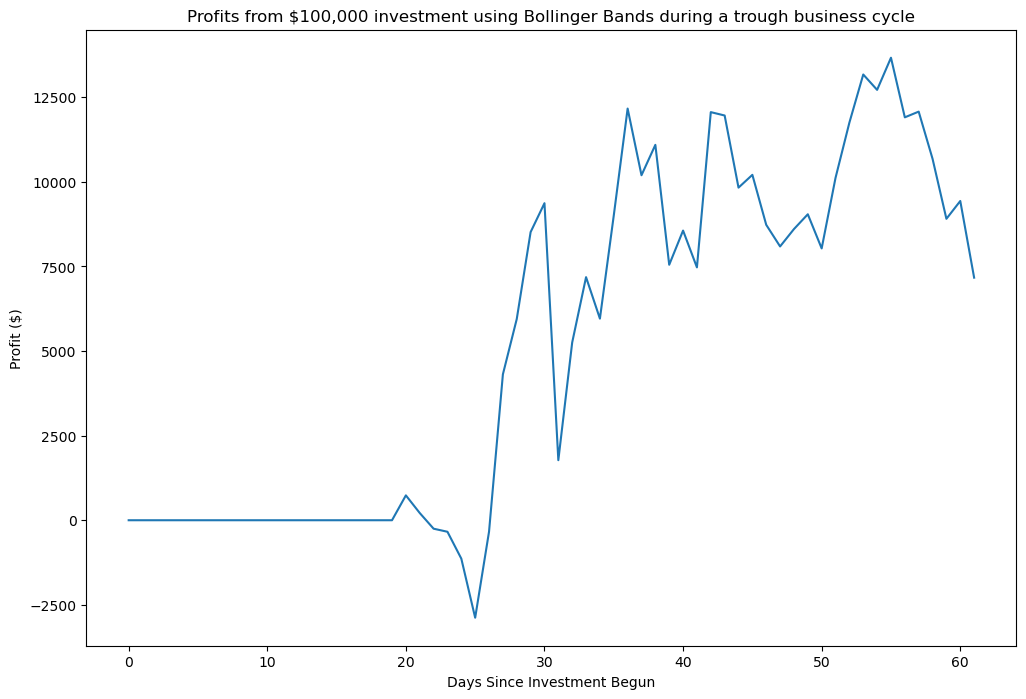

In [40]:
# display how the portfolio grew over time
plt.figure(figsize=(12,8))
plt.plot(bb_portfolio_investment['Portfolio Tracker']['trough']['Profit'])
plt.xlabel('Days Since Investment Begun')
plt.ylabel('Profit ($)')
plt.title('Profits from $100,000 investment using Bollinger Bands during a trough business cycle')

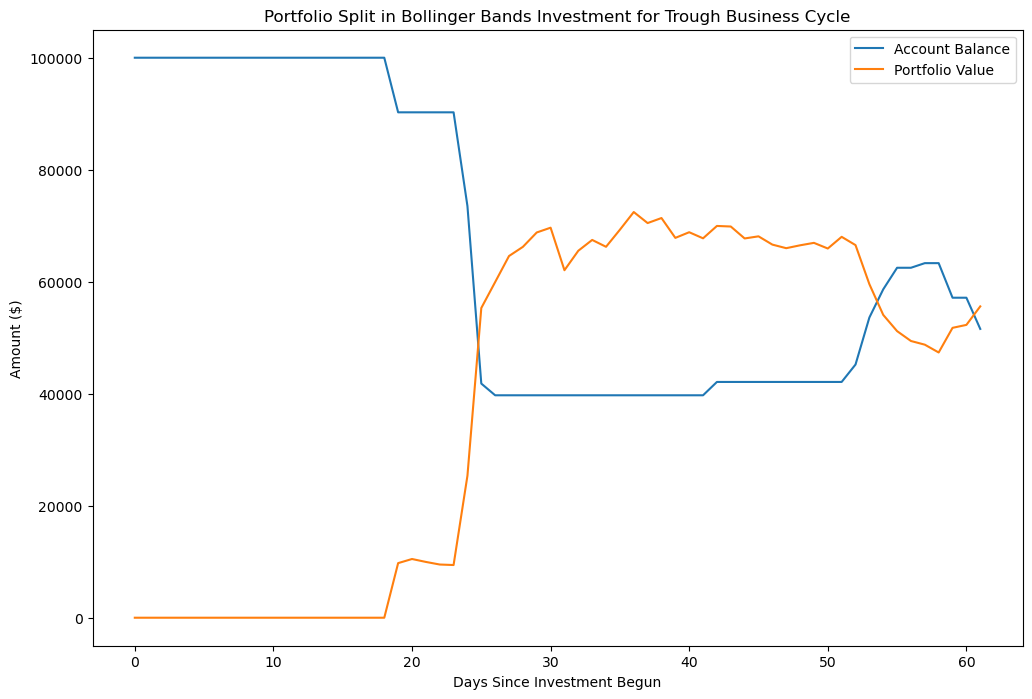

In [51]:
# create a plot of how account balance and portfolio value changes
plt.figure(figsize=(12,8))
plt.plot(bb_portfolio_investment['Portfolio Tracker']['trough']['Account Balance'],label='Account Balance')
plt.plot(bb_portfolio_investment['Portfolio Tracker']['trough']['Portfolio Value'],label='Portfolio Value')
plt.xlabel('Days Since Investment Begun')
plt.ylabel('Amount ($)')
plt.title('Portfolio Split in Bollinger Bands Investment for Trough Business Cycle')
plt.legend()

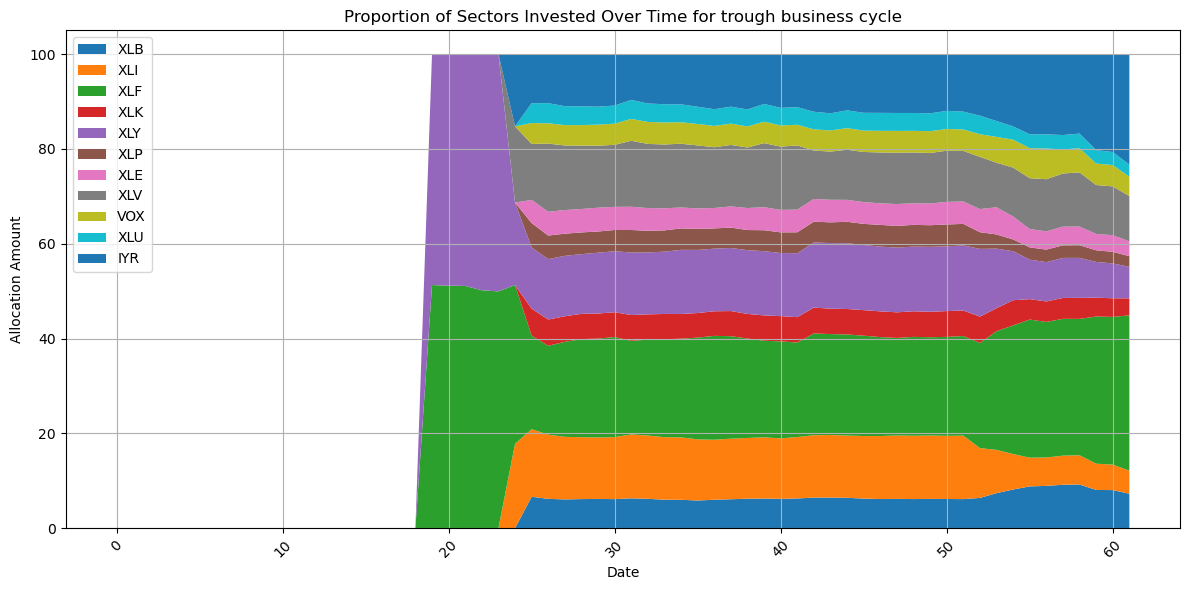

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
57,9.180357,6.133985,28.849075,4.405801,8.445196,2.646891,3.946161,11.212487,5.074879,3.026211,17.078956
58,9.221392,6.176260,28.752960,4.435628,8.426847,2.678212,3.925894,11.420192,5.099609,3.090828,16.772177
59,8.086970,5.527245,31.036839,3.985549,7.527465,2.451648,3.450421,10.313691,4.527483,2.829100,20.263588
60,8.048420,5.377628,31.144962,3.927300,7.355618,2.441709,3.501189,10.296784,4.495083,2.747641,20.663666


In [45]:
# create a plot of different sectors invested in over time
plot_sector_investment_changes(bb_portfolio_investment['Portfolio Tracker']['trough']['Sector Allocation'],'Proportion of Sectors Invested Over Time for trough business cycle')

In [44]:
# look at the investment history of 'XLV' healthcare sector during trough
bb_portfolio_investment['Stock Tracker']['trough']['XLV']

,Date,Share Price,Signal,Buy/Sell Amount ($),Buy/Sell Number of Shares,Shares ($) Ownership,Shares Ownership
0,2008-10-16,19.857855,Hold,0.0,0.0,0.000000,0.000000
1,2008-10-17,19.782064,Hold,0.0,0.0,0.000000,0.000000
2,2008-10-20,20.577896,Hold,0.0,0.0,0.000000,0.000000
3,2008-10-21,20.517260,Hold,0.0,0.0,0.000000,0.000000
4,2008-10-22,20.009439,Hold,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
57,2009-01-08,20.154236,Hold,0.0,0.0,5467.032073,271.259705
58,2009-01-09,19.940714,Hold,0.0,0.0,5409.112170,271.259705
59,2009-01-12,19.681456,Hold,0.0,0.0,5338.785848,271.259705
60,2009-01-13,19.849211,Hold,0.0,0.0,5384.291054,271.259705


### Stochastic Modeling
The above only concentrated on a single set of investment dates, to get the average returns to understand how bollinger bands actually perform, it is neccessary to rereun the simulation thousands of times so that the effects of standard deviation are reduced.

In [195]:
bb_average_return = calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,1000,0.01,0.01)

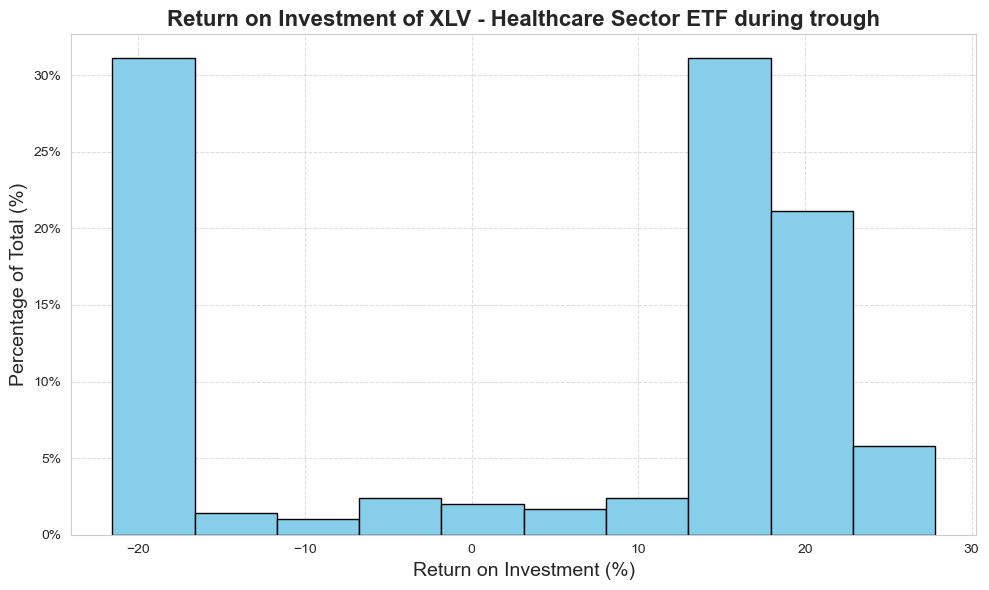

In [200]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

In [196]:
# get the mean of each stock during each time period
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Mean')

,trough,expansion,peak,contraction,all_data
XLB,-0.029593,2.584798,9.766264,10.791603,5.011131
XLI,2.900527,6.880604,13.383887,-14.406917,5.238759
XLF,-75.873412,-4.87829,7.946941,-28.523522,-4.438995
XLK,0.70924,4.937032,10.747122,-1.858801,2.751356
XLY,6.080887,7.859396,28.881756,4.779034,7.028195
XLP,-13.225207,3.095084,-1.50145,5.373152,3.765144
XLE,11.838581,9.826588,20.193686,6.99281,7.697522
XLV,4.412475,7.589642,3.688581,6.600993,6.718807
VOX,15.755505,11.741018,7.54455,4.193492,6.543275
XLU,-8.564124,4.683457,7.7972,-1.271964,4.778562


In [197]:
# get the mean return over the time period
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Mean').mean()

trough         -6.112308
expansion       5.203995
peak           10.070254
contraction    -0.307779
all_data        4.575258
dtype: float64

In [198]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Std')

,trough,expansion,peak,contraction,all_data
XLB,7.757045,20.560357,12.013905,16.998527,18.53284
XLI,20.177943,19.615171,6.944931,5.046014,16.266796
XLF,53.341583,17.017648,12.74696,15.795665,22.465392
XLK,3.278351,17.527584,7.623107,11.040627,16.749205
XLY,14.022198,15.384349,16.16122,12.203071,16.923245
XLP,19.221933,15.841657,1.704614,11.617518,15.708927
XLE,15.529311,16.477789,17.80293,14.6185,18.602655
XLV,18.077671,11.449254,7.17092,19.149459,16.305374
VOX,18.490643,18.382685,7.987251,12.321447,15.122937
XLU,15.697912,15.597007,15.287067,14.898975,15.225878


In [199]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Std').mean()

trough         19.063637
expansion      16.096683
peak           10.821492
contraction    13.220854
all_data       17.021890
dtype: float64

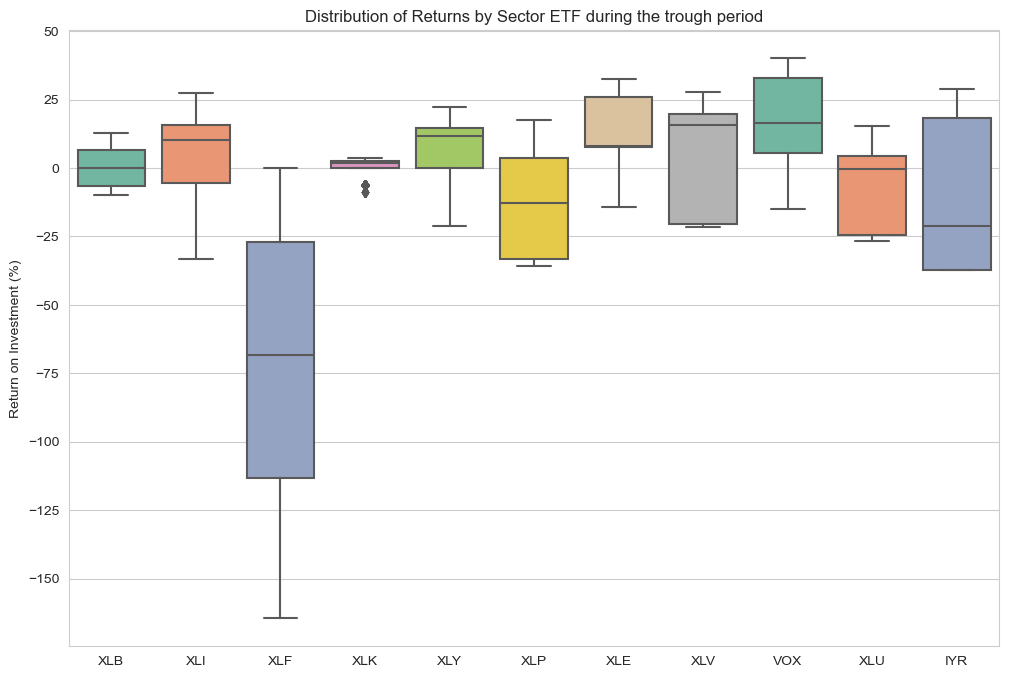

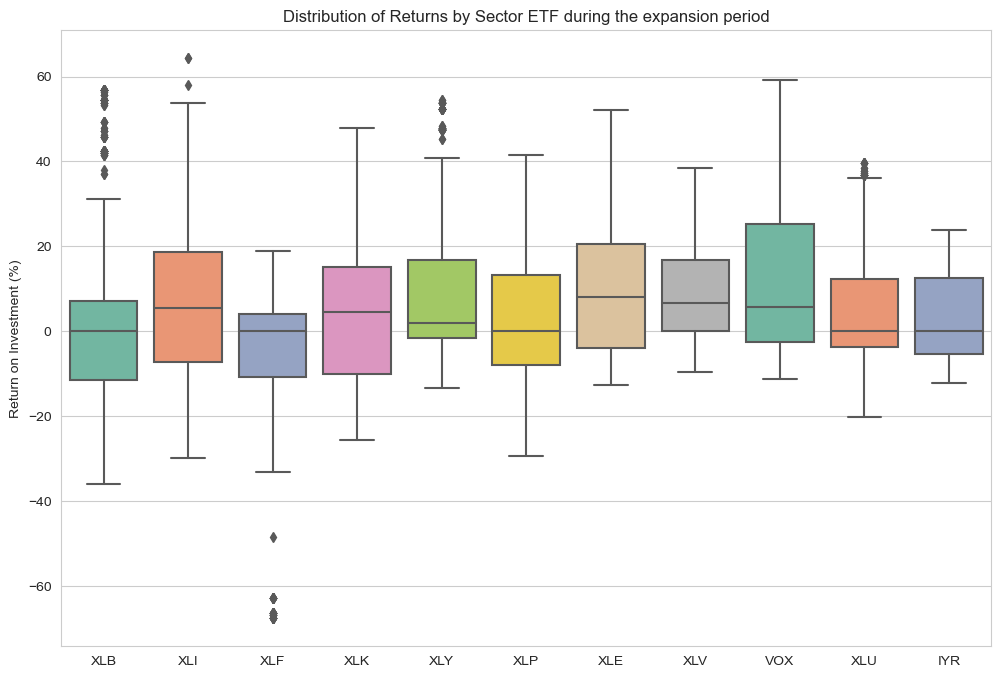

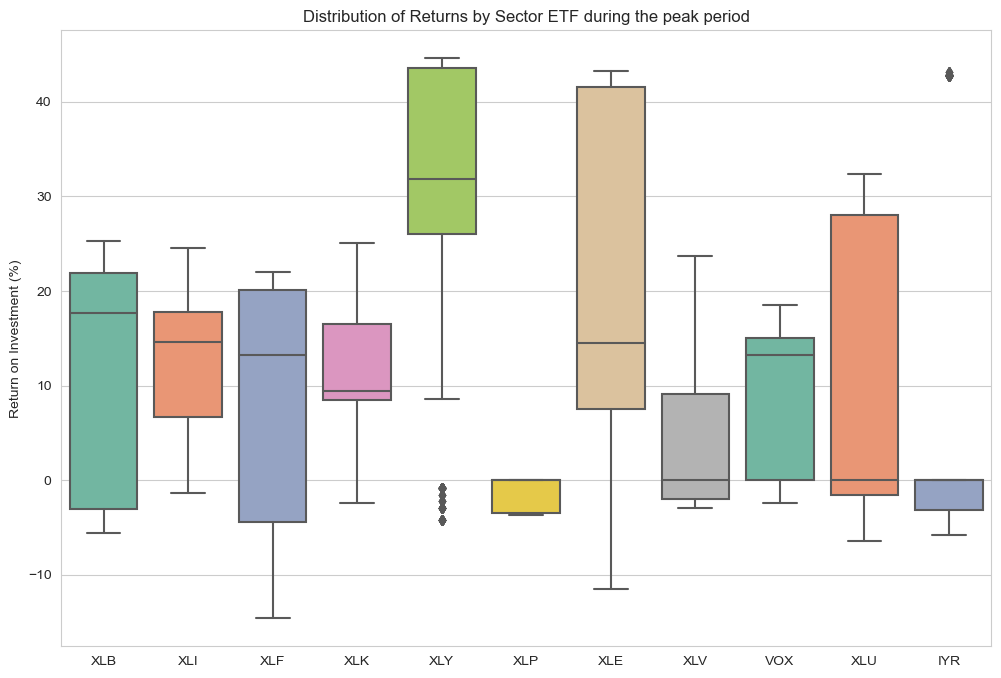

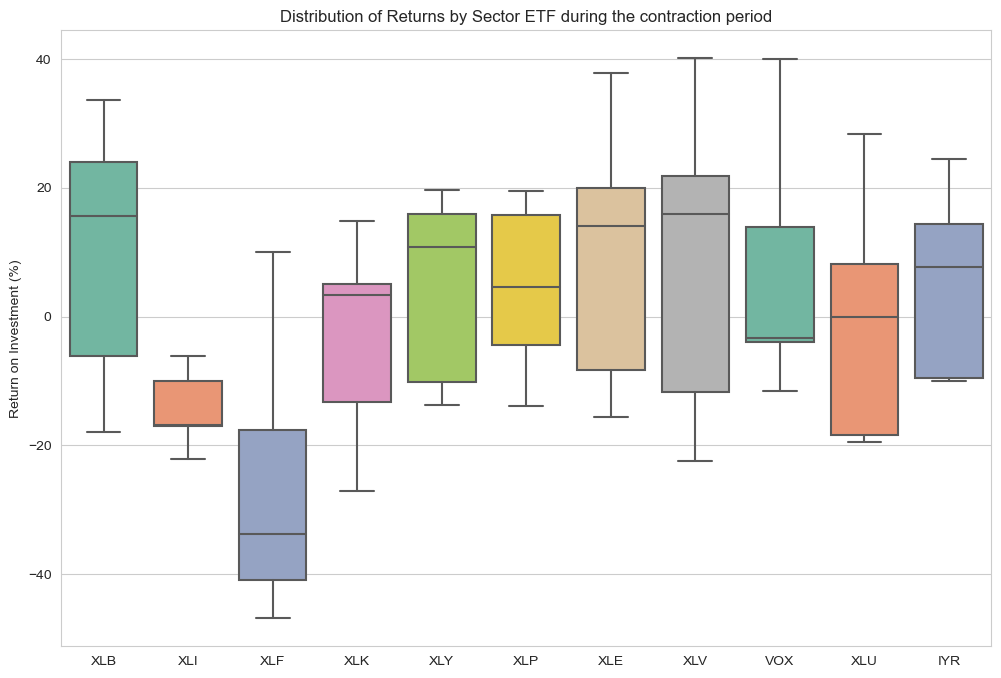

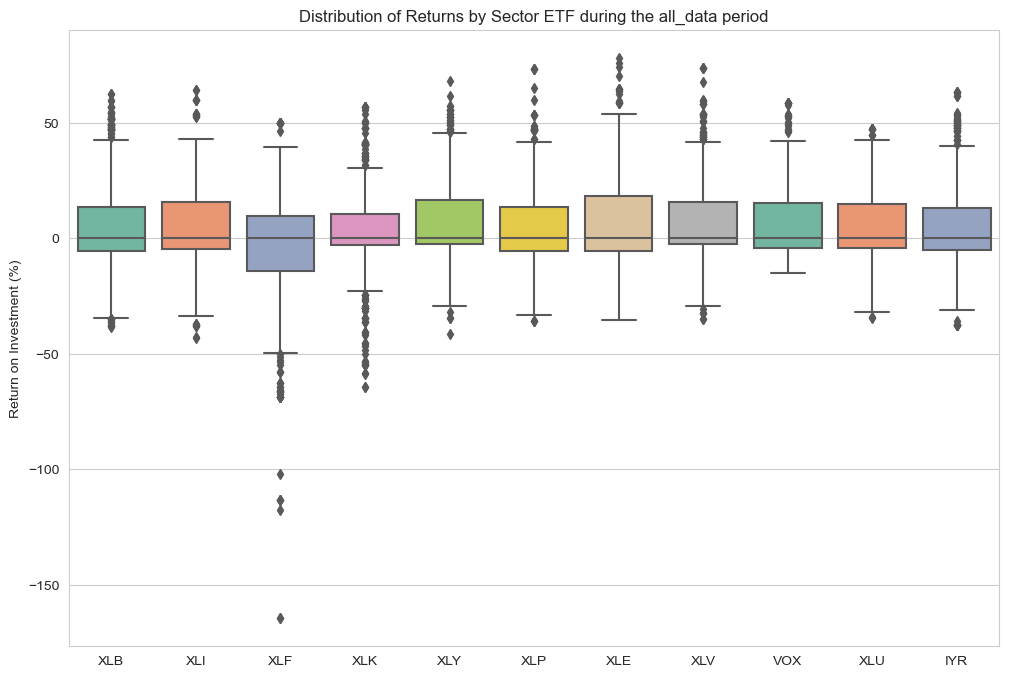

In [201]:
# create a boxplot of the above information for visualization
for period in economic_cycle_periods_list:
        # Boxplot of returns for each sector during the trough
        plt.figure(figsize=(12,8))
        sns.boxplot(data=[bb_average_return[period][ticker] for ticker in sector_etf_tickers], palette='Set2')
        plt.xticks(range(len(sector_etf_tickers)), sector_etf_tickers)
        plt.title(f'Distribution of Returns by Sector ETF during the {period} period')
        plt.ylabel('Return on Investment (%)')
        plt.show()